# Delft-FIAT Flood Impact Assessment for Juba

This notebook demonstrates how to use **Delft-FIAT** (Fast Impact Assessment Tool) to assess flood damages in **Juba, South Sudan** using existing flood hazard and exposure data.

## What is Delft-FIAT?

Delft-FIAT is a Python-based tool that rapidly assesses direct economic impacts from flooding. It calculates damages to buildings, infrastructure, and other assets based on:
- Flood hazard maps (water depth/level)
- Exposure data (asset locations and values)
- Vulnerability functions (depth-damage curves)

## Data Sources

This analysis uses:
- **Hazard data**: `data/hazard/Pokuantra_T50_BL.nc` - NetCDF flood depth map (50-year return period)
- **Exposure data**: `data/exposure/buildings.gpkg` - Building locations and attributes (GeoPackage)
- **Vulnerability curves**: `data/vulnerability/vulnerability_curves.csv` - Depth-damage functions

## 1. Import Libraries

In [1]:
import fiat
from fiat.fio import open_grid, open_csv, open_geom
from fiat.methods.flood import calculate_hazard, calculate_damage
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import toml

## 2. Create FIAT Configuration File

Create a TOML configuration file that defines all the settings for the FIAT model run.

In [ ]:
# Create FIAT configuration file
config = """
[model]
type = "geom"
risk = false

[model.srs]
value = "EPSG:4326"

[output]
path = "output/juba_flood_event"

[output.csv]
name1 = "output.csv"

[output.geom]
name1 = "spatial.gpkg"

[hazard]
file = "data/hazard/Pokuantra_T50_BL.nc"
elevation_reference = "DEM"

[hazard.settings]
srs = "EPSG:4326"

[exposure.geom]
file1 = "data/exposure/buildings.gpkg"

[exposure.geom.settings]
srs = "EPSG:4326"

[vulnerability]
file = "data/vulnerability/vulnerability_curves.csv"
step_size = 0.01
"""

# Save configuration file
config_path = Path("juba_flood_config.toml")
with open(config_path, "w") as f:
    f.write(config)

print(f"Configuration file created: {config_path}")
print("\nConfiguration contents:")
print(config)

## 3. Check Data Files

Before running FIAT, let's verify that all required data files exist and check their structure.

In [ ]:
# Check if data files exist
data_files = {
    'Hazard': Path("data/hazard/Pokuantra_T50_BL.nc"),
    'Exposure': Path("data/exposure/buildings.gpkg"),
    'Vulnerability': Path("data/vulnerability/vulnerability_curves.csv")
}

print("Data Files Status:")
print("=" * 60)
for name, path in data_files.items():
    exists = path.exists()
    size = path.stat().st_size if exists else 0
    status = "✓ EXISTS" if exists and size > 0 else "✗ MISSING/EMPTY"
    print(f"{name:25} {status:15} {f'({size:,} bytes)' if exists else ''}")
    
print("\n" + "=" * 60)

# Check hazard file
hazard_path = data_files['Hazard']
if hazard_path.exists() and hazard_path.stat().st_size > 0:
    import xarray as xr
    try:
        hazard_ds = xr.open_dataset(hazard_path)
        print("\n📊 Hazard Data (Pokuantra_T50_BL.nc):")
        print(f"   Variables: {list(hazard_ds.data_vars)}")
        print(f"   Coordinates: {list(hazard_ds.coords)}")
        print(f"   Dimensions: {dict(hazard_ds.dims)}")
        
        # Show data variable details
        for var in hazard_ds.data_vars:
            print(f"\n   Variable '{var}':")
            print(f"     Shape: {hazard_ds[var].shape}")
            print(f"     Min: {float(hazard_ds[var].min()):.3f}")
            print(f"     Max: {float(hazard_ds[var].max()):.3f}")
            print(f"     Mean: {float(hazard_ds[var].mean()):.3f}")
        
        hazard_ds.close()
    except Exception as e:
        print(f"\n⚠️  Could not read hazard file: {e}")
else:
    print("\n⚠️  Hazard file is missing or empty!")

# Check exposure file (GeoPackage)
exp_path = data_files['Exposure']
if exp_path.exists() and exp_path.stat().st_size > 0:
    try:
        exp_data = gpd.read_file(exp_path)
        print(f"\n📊 Exposure Data (buildings.gpkg):")
        print(f"   Total buildings: {len(exp_data)}")
        print(f"   Columns: {list(exp_data.columns)}")
        print(f"   CRS: {exp_data.crs}")
        print(f"   Geometry type: {exp_data.geometry.type.unique()}")
        
        # Show spatial extent
        bounds = exp_data.total_bounds
        print(f"   Extent: [{bounds[0]:.4f}, {bounds[1]:.4f}, {bounds[2]:.4f}, {bounds[3]:.4f}]")
        
        print("\n   First few rows:")
        display(exp_data.head())
    except Exception as e:
        print(f"\n⚠️  Could not read exposure file: {e}")
else:
    print("\n⚠️  Exposure file is missing or empty!")

# Check vulnerability file
vuln_path = data_files['Vulnerability']
if vuln_path.exists() and vuln_path.stat().st_size > 0:
    try:
        vuln_data = pd.read_csv(vuln_path)
        print(f"\n📊 Vulnerability Curves (vulnerability_curves.csv):")
        print(f"   Rows: {len(vuln_data)}")
        print(f"   Columns: {list(vuln_data.columns)}")
        print("\n   Data preview:")
        display(vuln_data.head(10))
    except Exception as e:
        print(f"\n⚠️  Could not read vulnerability file: {e}")
else:
    print("\n⚠️  Vulnerability file is missing or empty!")

## 4. Run FIAT Model

Execute the FIAT model using the configuration file. This will process the hazard, exposure, and vulnerability data to calculate flood damages.

In [10]:
# Run FIAT model
print("Running FIAT flood impact assessment for Juba...")
print("=" * 60)

! fiat run juba_flood_config.toml

Running FIAT flood impact assessment for Juba...

###############################################################

        #########    ##          ##      ##############
        ##           ##         ####         ######
        ##           ##         ####           ##
        ##           ##        ##  ##          ##
        ######       ##        ##  ##          ##
        ##           ##       ########         ##
        ##           ##      ##      ##        ##
        ##           ##     ##        ##       ##
        ##           ##    ##          ##      ##

###############################################################

                Fast Impact Assessment Tool
                © Deltares

2025-11-26 13:12:00 INFO    Delft-Fiat version: 0.4.0
2025-11-26 13:12:00 INFO    Using settings from 'c:\projects\Capacity-Building-ICPAC-for-climate-services\2_IBF_Flood_Damage\3_Flood_Damage_Model\juba_flood_config.toml'
2025-11-26 13:12:00 INFO    Model srs set to: 'EPSG:4326'
2025-11

## 5. Load and Analyze Results

Load the FIAT output files and analyze the damage assessment results.

In [18]:
# Load FIAT output
output_path = Path("output/juba_flood_event")
output_csv = output_path / "output.csv"
output_gpkg = output_path / "spatial.gpkg"

# Check if output exists
if not output_csv.exists():
    print("⚠️  No output file found. The model may not have run successfully.")
    print("Please check the FIAT execution output above for errors.")
else:
    # Load output CSV
    results_df = pd.read_csv(output_csv).set_index('object_id')
    
    print("✓ Results loaded successfully!")
    print(f"\nOutput columns: {results_df.columns}")
    print(f"Number of objects assessed: {len(results_df)}")
    
    # Display first few rows
    print("\nFirst few rows of results:")
    display(results_df.head(10))

✓ Results loaded successfully!

Output columns: Index(['inun_depth', 'red_fact', 'damage_structure', 'damage_contents',
       'damage_indirect', 'damage_totaal', 'total_damage'],
      dtype='object')
Number of objects assessed: 26522

First few rows of results:


,inun_depth,red_fact,damage_structure,damage_contents,damage_indirect,damage_totaal,total_damage
object_id,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## 6. Calculate Summary Statistics

Compute key statistics from the damage assessment results.

In [19]:
# Calculate summary statistics
if output_csv.exists():
    # Get damage columns
    damage_cols = [col for col in results_df.columns if 'damage' in col.lower()]
    
    # Total damages
    total_damage = results_df['total_damage'].sum()
    
    # Buildings affected (with damage > 0)
    affected = results_df[results_df['total_damage'] > 0]
    n_affected = len(affected)
    n_total = len(results_df)
    
    # Inundation depth statistics
    flooded = results_df[results_df['inun_depth'] > 0]
    
    print("\n" + "=" * 60)
    print("FLOOD IMPACT ASSESSMENT RESULTS - JUBA, SOUTH SUDAN")
    print("=" * 60)
    print(f"\n📊 EXPOSURE:")
    print(f"   Total buildings assessed: {n_total:,}")
    print(f"   Buildings affected by flooding: {n_affected:,} ({n_affected/n_total*100:.1f}%)")
    print(f"   Buildings not affected: {n_total - n_affected:,}")
    
    print(f"\n💧 FLOOD CHARACTERISTICS:")
    print(f"   Mean inundation depth (all): {results_df['inun_depth'].mean():.2f} m")
    print(f"   Mean inundation depth (flooded): {flooded['inun_depth'].mean():.2f} m")
    print(f"   Max inundation depth: {results_df['inun_depth'].max():.2f} m")
    
    print(f"\n💰 ECONOMIC DAMAGES:")
    print(f"   Total damage: ${total_damage:,.2f}")
    if 'damage_structure' in results_df.columns:
        print(f"   Structure damage: ${results_df['damage_structure'].sum():,.2f}")
    print(f"   Mean damage per building (all): ${results_df['total_damage'].mean():,.2f}")
    print(f"   Mean damage per affected building: ${affected['total_damage'].mean():,.2f}")
    print(f"   Median damage per affected building: ${affected['total_damage'].median():,.2f}")
    print(f"   Max damage (single building): ${results_df['total_damage'].max():,.2f}")
    
    print("\n" + "=" * 60)
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Metric': [
            'Total Buildings',
            'Affected Buildings',
            'Percentage Affected',
            'Mean Inundation Depth (m)',
            'Max Inundation Depth (m)',
            'Total Damage ($)',
            'Mean Damage per Building ($)',
            'Max Damage ($)'
        ],
        'Value': [
            n_total,
            n_affected,
            f"{n_affected/n_total*100:.1f}%",
            f"{flooded['inun_depth'].mean():.2f}",
            f"{results_df['inun_depth'].max():.2f}",
            f"{total_damage:,.2f}",
            f"{affected['total_damage'].mean():,.2f}",
            f"{results_df['total_damage'].max():.2f}"
        ]
    })
    
    display(summary)
else:
    print("No results to analyze. Please ensure FIAT ran successfully.")


FLOOD IMPACT ASSESSMENT RESULTS - JUBA, SOUTH SUDAN

📊 EXPOSURE:
   Total buildings assessed: 26,522
   Buildings affected by flooding: 595 (2.2%)
   Buildings not affected: 25,927

💧 FLOOD CHARACTERISTICS:
   Mean inundation depth (all): 0.64 m
   Mean inundation depth (flooded): 0.64 m
   Max inundation depth: 2.93 m

💰 ECONOMIC DAMAGES:
   Total damage: $27,851,412.85
   Structure damage: $6,705,300.09
   Mean damage per building (all): $1,050.12
   Mean damage per affected building: $46,809.10
   Median damage per affected building: $15,422.56
   Max damage (single building): $1,268,143.43



,Metric,Value
0,Total Buildings,26522
1,Affected Buildings,595
2,Percentage Affected,2.2%
3,Mean Inundation Depth (m),0.64
4,Max Inundation Depth (m),2.93
5,Total Damage ($),"27,851,412.85"
6,Mean Damage per Building ($),"46,809.10"
7,Max Damage ($),1268143.43


## 7. Visualize Flood Hazard

Load and visualize the flood hazard map.

Hazard variable: Band1
Dtype: float32
Shape (full): (39081, 35935)
Min depth: 0.20 m
Max depth: 4.12 m
Mean depth: 0.88 m
Shape (downsampled): (196, 180)


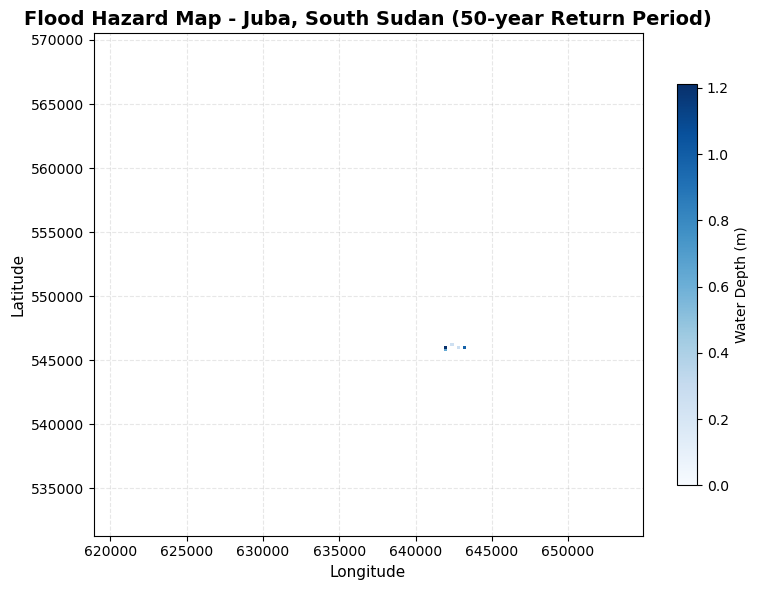

In [ ]:
hazard_path = Path("data/hazard/Pokuantra_T50_BL.nc")


if hazard_path.exists():
    hazard_ds = xr.open_dataset(hazard_path)

    # Only keep numeric data variables
    numeric_vars = [
        v for v in hazard_ds.data_vars
        if np.issubdtype(hazard_ds[v].dtype, np.number)
    ]

    if len(numeric_vars) == 0:
        print("No numeric data variables found in hazard file.")
        print("Variables present:", list(hazard_ds.data_vars))
    else:
        var_name = numeric_vars[0]
        hazard_data = hazard_ds[var_name]

        print(f"Hazard variable: {var_name}")
        print(f"Dtype: {hazard_data.dtype}")
        print(f"Shape (full): {hazard_data.shape}")

        # Stats on full data (these are cheap; they reduce the array)
        min_depth = hazard_data.min(skipna=True).item()
        max_depth = hazard_data.max(skipna=True).item()
        mean_depth = hazard_data.mean(skipna=True).item()

        print(f"Min depth: {min_depth:.2f} m")
        print(f"Max depth: {max_depth:.2f} m")
        print(f"Mean depth: {mean_depth:.2f} m")

        stride = 200  

        ydim, xdim = hazard_data.dims[-2], hazard_data.dims[-1]
        hazard_small = hazard_data.isel(
            {
                ydim: slice(0, None, stride),
                xdim: slice(0, None, stride),
            }
        ).astype("float32")

        print(f"Shape (downsampled): {hazard_small.shape}")

        # Plot downsampled hazard map
        fig, ax = plt.subplots(figsize=(8, 6))

        im = hazard_small.plot(
            ax=ax,
            cmap="Blues",
            vmin=0,
            cbar_kwargs={"label": "Water Depth (m)", "shrink": 0.8},
        )

        ax.set_title(
            "Flood Hazard Map - Juba, South Sudan (50-year Return Period)",
            fontsize=14,
            fontweight="bold",
        )
        ax.set_xlabel("Longitude", fontsize=11)
        ax.set_ylabel("Latitude", fontsize=11)
        ax.grid(True, alpha=0.3, linestyle="--")

        plt.tight_layout()
        plt.show()

        hazard_ds.close()
else:
    print("Hazard file not found")

## 8. Visualize Damage Results

Create comprehensive visualizations of the damage assessment results.

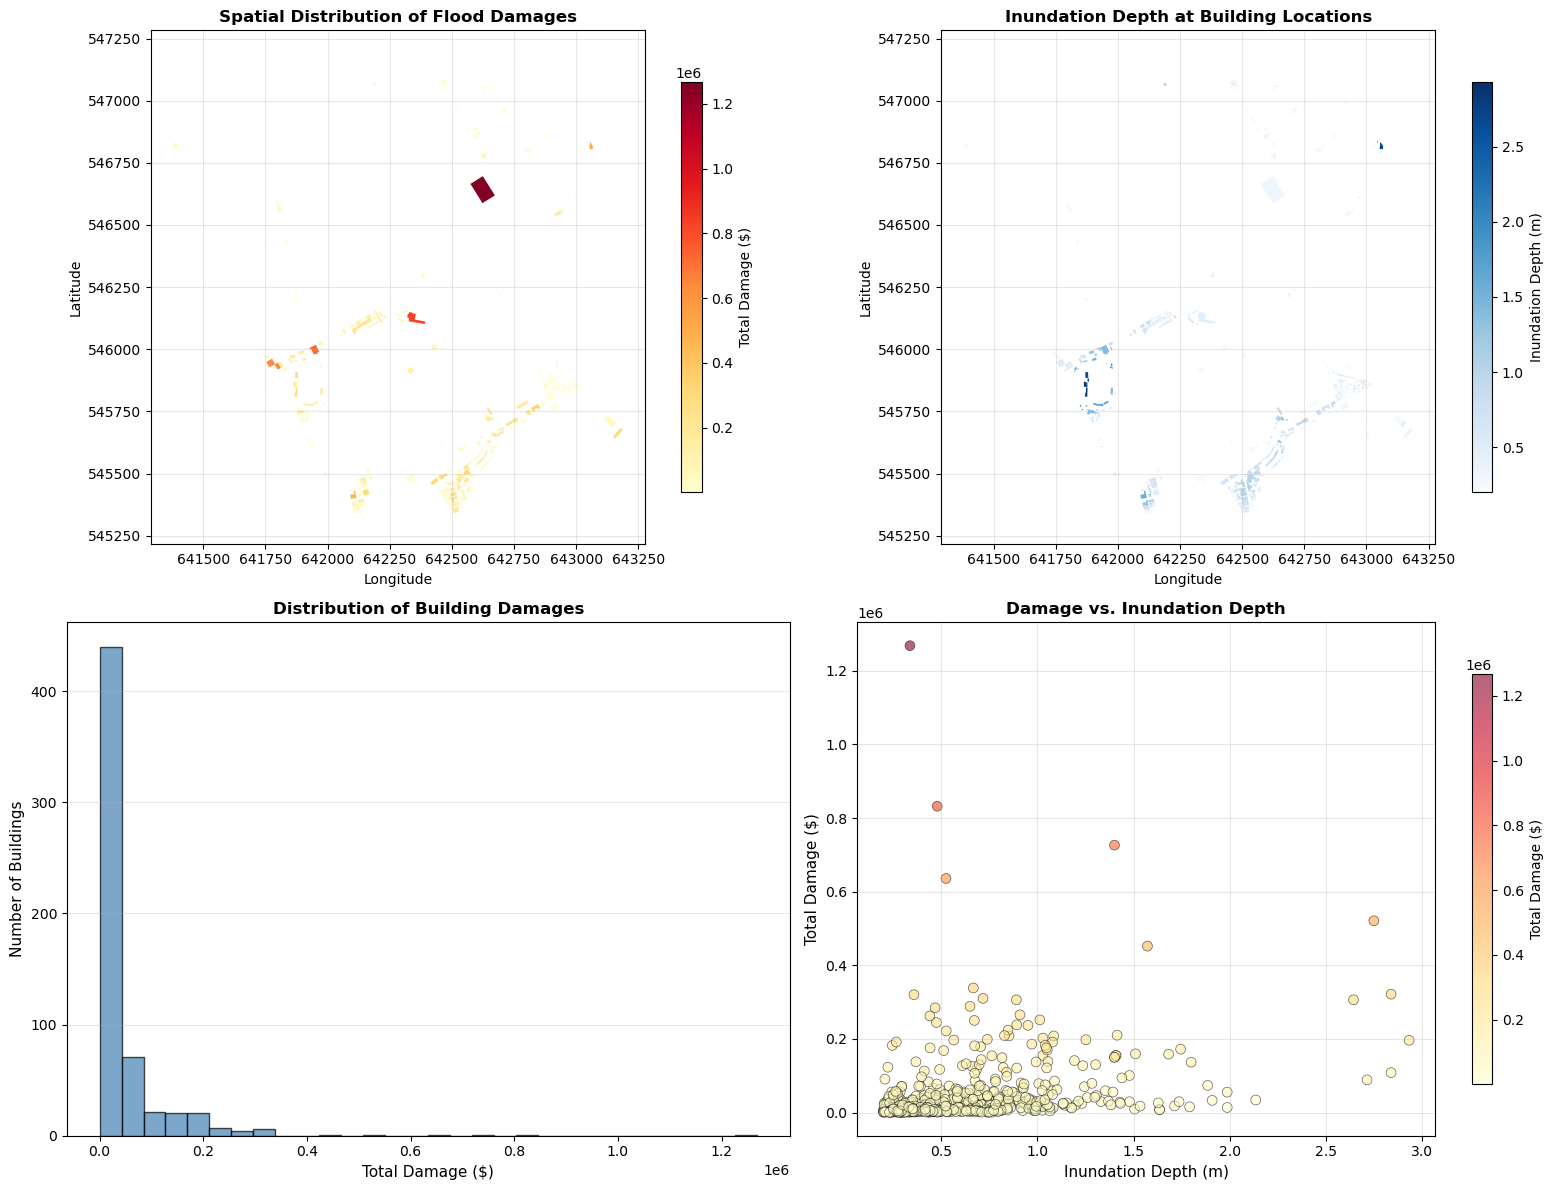

✓ Visualizations created for 26522 buildings
  - Buildings with damage: 595
  - Buildings with inundation: 595


In [14]:
# Visualize damage results
if output_csv.exists() and output_gpkg.exists():
    # Load spatial results
    results_gdf = gpd.read_file(output_gpkg)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Spatial distribution of damages
    ax1 = axes[0, 0]
    results_gdf_damaged = results_gdf[results_gdf['total_damage'] > 0]
    if len(results_gdf_damaged) > 0:
        results_gdf_damaged.plot(
            column='total_damage',
            ax=ax1,
            cmap='YlOrRd',
            markersize=50,
            legend=True,
            legend_kwds={'label': 'Total Damage ($)', 'shrink': 0.8}
        )
        ax1.set_title('Spatial Distribution of Flood Damages', fontsize=12, fontweight='bold')
    else:
        ax1.text(0.5, 0.5, 'No damages to display', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Spatial Distribution of Flood Damages', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.grid(True, alpha=0.3)
    
    # 2. Inundation depth distribution
    ax2 = axes[0, 1]
    results_gdf_flooded = results_gdf[results_gdf['inun_depth'] > 0]
    if len(results_gdf_flooded) > 0:
        results_gdf_flooded.plot(
            column='inun_depth',
            ax=ax2,
            cmap='Blues',
            markersize=50,
            legend=True,
            legend_kwds={'label': 'Inundation Depth (m)', 'shrink': 0.8}
        )
        ax2.set_title('Inundation Depth at Building Locations', fontsize=12, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No inundation to display', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Inundation Depth at Building Locations', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.grid(True, alpha=0.3)
    
    # 3. Damage histogram
    ax3 = axes[1, 0]
    if len(results_gdf_damaged) > 0:
        ax3.hist(results_gdf_damaged['total_damage'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        ax3.set_xlabel('Total Damage ($)', fontsize=11)
        ax3.set_ylabel('Number of Buildings', fontsize=11)
        ax3.set_title('Distribution of Building Damages', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
    else:
        ax3.text(0.5, 0.5, 'No damages to display', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Distribution of Building Damages', fontsize=12, fontweight='bold')
    
    # 4. Depth vs Damage scatter plot
    ax4 = axes[1, 1]
    if len(results_gdf_damaged) > 0:
        scatter = ax4.scatter(
            results_gdf_damaged['inun_depth'], 
            results_gdf_damaged['total_damage'],
            c=results_gdf_damaged['total_damage'],
            cmap='YlOrRd',
            s=50,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        plt.colorbar(scatter, ax=ax4, label='Total Damage ($)', shrink=0.8)
        ax4.set_xlabel('Inundation Depth (m)', fontsize=11)
        ax4.set_ylabel('Total Damage ($)', fontsize=11)
        ax4.set_title('Damage vs. Inundation Depth', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No data to display', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Damage vs. Inundation Depth', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Visualizations created for {len(results_gdf)} buildings")
    print(f"  - Buildings with damage: {len(results_gdf_damaged)}")
    print(f"  - Buildings with inundation: {len(results_gdf_flooded)}")
else:
    print("Output files not found. Please ensure FIAT ran successfully.")

## 9. Export Results Summary

Save summary statistics and detailed results for further analysis.

In [ ]:
# Export summary results
if output_csv.exists():
    # Create summary report
    summary_report = {
        'Location': 'Juba, South Sudan',
        'Analysis Date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Total Buildings': len(results_df),
        'Affected Buildings': len(results_df[results_df['total_damage'] > 0]),
        'Percentage Affected (%)': len(results_df[results_df['total_damage'] > 0]) / len(results_df) * 100,
        'Total Damage ($)': results_df['total_damage'].sum(),
        'Mean Damage per Building ($)': results_df['total_damage'].mean(),
        'Median Damage ($)': results_df['total_damage'].median(),
        'Max Damage ($)': results_df['total_damage'].max(),
        'Mean Inundation Depth (m)': results_df[results_df['inun_depth'] > 0]['inun_depth'].mean(),
        'Max Inundation Depth (m)': results_df['inun_depth'].max(),
    }
    
    if 'damage_structure' in results_df.columns:
        summary_report['Structure Damage ($)'] = results_df['damage_structure'].sum()
    
    # Save summary
    summary_df = pd.DataFrame([summary_report]).T
    summary_df.columns = ['Value']
    summary_path = Path("output/juba_flood_event/summary_report.csv")
    summary_df.to_csv(summary_path)
    
    print("✓ Results exported successfully!")
    print(f"\nOutput files:")
    print(f"  📄 Detailed results: {output_csv}")
    print(f"  🗺️  Spatial results: {output_gpkg}")
    print(f"  📊 Summary report: {summary_path}")
    
    print("\n" + "=" * 60)
    print("Summary Report:")
    print("=" * 60)
    display(summary_df)
else:
    print("No results to export. Please ensure FIAT ran successfully.")

## 10. Validate Results (Optional)

Perform basic validation checks on the results to ensure they are reasonable.

In [ ]:
# Validate results
if output_csv.exists():
    print("Validation Checks:")
    print("=" * 60)
    
    # Check 1: No negative damages
    negative_damages = results_df[results_df['total_damage'] < 0]
    if len(negative_damages) == 0:
        print("✓ No negative damages found")
    else:
        print(f"⚠️  Found {len(negative_damages)} records with negative damages")
    
    # Check 2: Damage should not exceed max potential damage
    if 'max_damage_structure' in results_df.columns:
        over_max = results_df[results_df['damage_structure'] > results_df['max_damage_structure']]
        if len(over_max) == 0:
            print("✓ No damages exceeding maximum potential damage")
        else:
            print(f"⚠️  Found {len(over_max)} records with damage exceeding max potential")
    
    # Check 3: Buildings with no inundation should have no damage
    no_flood_damage = results_df[(results_df['inun_depth'] == 0) & (results_df['total_damage'] > 0)]
    if len(no_flood_damage) == 0:
        print("✓ No damage in non-flooded areas")
    else:
        print(f"⚠️  Found {len(no_flood_damage)} buildings with damage but no inundation")
    
    # Check 4: Reasonable damage range
    if results_df['total_damage'].max() > 0:
        damage_range = results_df[results_df['total_damage'] > 0]['total_damage']
        print(f"✓ Damage range: ${damage_range.min():.2f} - ${damage_range.max():.2f}")
    
    # Check 5: Correlation between depth and damage
    if len(results_df[results_df['inun_depth'] > 0]) > 1:
        correlation = results_df[results_df['inun_depth'] > 0][['inun_depth', 'total_damage']].corr().iloc[0, 1]
        print(f"✓ Correlation (depth vs damage): {correlation:.3f}")
        if correlation > 0.5:
            print("  → Strong positive correlation (expected)")
        elif correlation > 0:
            print("  → Weak positive correlation")
        else:
            print("  ⚠️ Unexpected negative correlation")
    
    print("=" * 60)
else:
    print("No results to validate.")

## Summary

This notebook demonstrated:
1. Loading a flood hazard map from NetCDF (`data/hazard/event_map.nc`)
2. Loading or creating exposure data (building locations and values)
3. Loading or defining vulnerability functions (depth-damage curves)
4. Running FIAT to calculate flood damages for Juba, South Sudan
5. Visualizing and exporting results

### Next Steps:
- Replace synthetic exposure data with real building data for Juba
- Use appropriate vulnerability functions for your region
- Incorporate ground elevation data for more accurate assessments
- Run scenarios for different return periods to calculate risk
- Consider adaptation measures and their effectiveness

### Resources:
- [Delft-FIAT Documentation](https://deltares.github.io/Delft-FIAT/)
- [HydroMT-FIAT](https://deltares.github.io/hydromt_fiat/) for automated model setup
- [GitHub Repository](https://github.com/Deltares/Delft-FIAT)